Inductive Source Simulation: Conductive Sphere in Vacuum
=================================================

## Geoscientific Problem

For this code comparison, we simulated secondary magnetic fields over a conductive and susceptible sphere in vacuum. The sphere had a conductivity of $\sigma$ = 0.25 S/m and a susceptibility of $\chi$ = 4 SI. The center of the sphere was located at (0,0,-50) and had a radius of $a$ = 8 m.

Secondary magnetic fields were simulated for x, y and z oriented magnetic dipoles sources at (-5,0,10). The x, y and z components of the response were simulated for each source at (5,0,10). We plot only the horizontal coaxial, horizontal coplanar and vertical coplanar data.

## Codes/Formulations Being Compared

**Analytic Solution:** Wait and Spies analytic solution. See https://em.geosci.xyz/content/maxwell3_fdem/inductive_sources/sphere/index.html for a summary of the solution. Reference: J. R. Wait. A conductive sphere in a time varying magnetic field. Geophysics, 16:666–672, 1951.

**SimPEG 3D OcTree Formulation (H-formulation):**

**UBC E3DRH v1:** [E3DRH v1](https://e3drh.readthedocs.io/en/e3drh/) is a voxel cell FDEM forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) license. The numerical approach of the forward simulation is described in the [online manual's theory section](https://e3drh.readthedocs.io/en/e3drh/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

**UBC E3DRH v2:** [E3DRH v2](https://e3drh.readthedocs.io/en/e3drh_v2/) is a voxel cell FDEM forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) license. The numerical approach of the forward simulation is described in the [online manual's theory section](https://e3drh.readthedocs.io/en/e3drh_v2/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

## Loading Assets Into the SimPEG Framework

We start by importing any necessary packages for running the notebook.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from discretize import TreeMesh
from SimPEG import maps

mpl.rcParams.update({"font.size": 10})

frequencies = np.logspace(2, 5, 10)

plot_analytic = True
plot_simpeg_octree = True
plot_ubc_e3drh_v1 = True
plot_ubc_e3drh_v2 = True

Next we download the mesh, model and simulated data for each code.

In [2]:
# For each package, download .tar files

The mesh, model and predicted data for each code are then loaded into the SimPEG framework for plotting.

In [3]:
rootdir = './../../../assets/fdem/sphere_vacuum_susceptible_fwd'
mesh_simpeg = TreeMesh.read_UBC(rootdir+'_simpeg/octree_mesh.txt')
con_model_simpeg = TreeMesh.read_model_UBC(mesh_simpeg, rootdir+'_simpeg/model.con')
sus_model_simpeg = TreeMesh.read_model_UBC(mesh_simpeg, rootdir+'_simpeg/model.sus')

data_list = []
legend_str = []
style_list_real = ['k-o', 'b-o', 'r-o', 'g-o', 'c-o']
style_list_imag = ['k--s', 'b--s', 'r--s', 'g--s', 'c--s']

if plot_analytic:
    fname = '_simpeg/analytic.txt'
    data_array = np.loadtxt(rootdir+fname, skiprows=1)[:, 1:]
    data_array = np.reshape(data_array, (3, len(frequencies), 6))
    data_list.append(data_array)
    legend_str += ['Analytic (real)', 'Analytic (imag)']

if plot_simpeg_octree:
    fname = '_simpeg/dpred_octree.txt'
    data_array = np.loadtxt(rootdir+fname, skiprows=1)[:, 1:]
    data_array = np.reshape(data_array, (3, len(frequencies), 6))
    data_list.append(data_array)
    legend_str += ['OcTree (real)', 'OcTree (imag)']

if plot_ubc_e3drh_v1:
    fname = '_ubc_octree/fwd_v1/dpred_fwd.txt'
    d_e3dv1 = np.loadtxt(rootdir+fname, comments='%')
    d_e3dv1 = d_e3dv1[:, 9:15]  # extract Hx, Hy and Hz columns
    
    # Convert -iwt to +iwt
    d_e3dv1 = np.c_[
        d_e3dv1[:, 0], -d_e3dv1[:, 1],
        d_e3dv1[:, 2], -d_e3dv1[:, 3],
        d_e3dv1[:, 4], -d_e3dv1[:, 5]
    ]
    
    d_e3dv1 = np.reshape(d_e3dv1, (3, len(frequencies), 6))
    data_list.append(d_e3dv1)
    legend_str += ['E3DRH v1 (real)', 'E3DRH v1 (imag)']

if plot_ubc_e3drh_v2:
    fname = '_ubc_octree/fwd_v2/dpredFWD.txt'
    d_e3dv2 = np.loadtxt(rootdir+fname) 

    # Extract Hx, Hy and Hz, and convert -iwt to +iwt
    d_e3dv2 = np.c_[
        d_e3dv2[0::3, 0], -d_e3dv2[0::3, 1],
        d_e3dv2[1::3, 0], -d_e3dv2[1::3, 1],
        d_e3dv2[2::3, 0], -d_e3dv2[2::3, 1]
    ]

    d_e3dv2 = np.reshape(d_e3dv2, (3, len(frequencies), 6))
    data_list.append(d_e3dv2)
    legend_str += ['E3DRH v2 (real)', 'E3DRH v2 (imag)']

## Plot Geophysical Scenario

Below, we plot the conductivity model and survey geometry for the forward simulation.

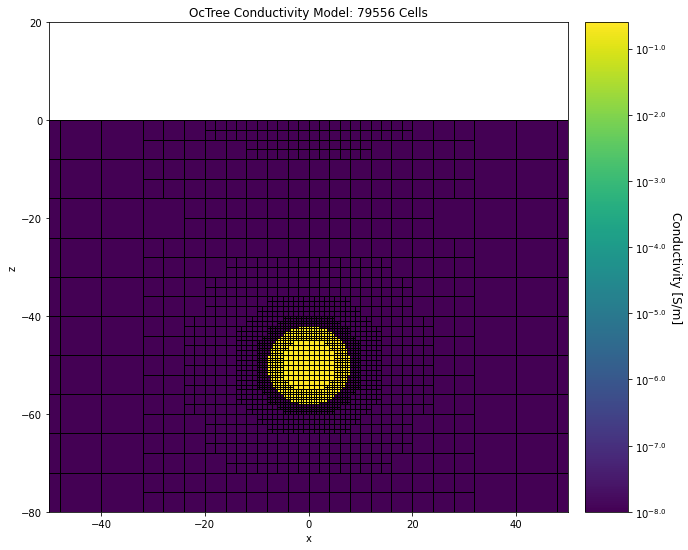

In [4]:
fig = plt.figure(figsize=(12,8))
ind_active = mesh_simpeg.cell_centers[:, 2] < 0
plotting_map = maps.InjectActiveCells(mesh_simpeg, ind_active, np.nan)
log_model = np.log10(con_model_simpeg[ind_active])

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh_simpeg.plot_slice(
    plotting_map * log_model,
    normal="Y", ax=ax1, ind=int(mesh_simpeg.h[1].size / 2), clim=(np.min(log_model), np.max(log_model)),
    grid=True
)

ax1.set_xlim([-50, 50])
ax1.set_ylim([-80, 20])
ax1.set_title("OcTree Conductivity Model: {} Cells".format(mesh_simpeg.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.min(log_model), vmax=np.max(log_model)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

And here we plot the susceptibility model.

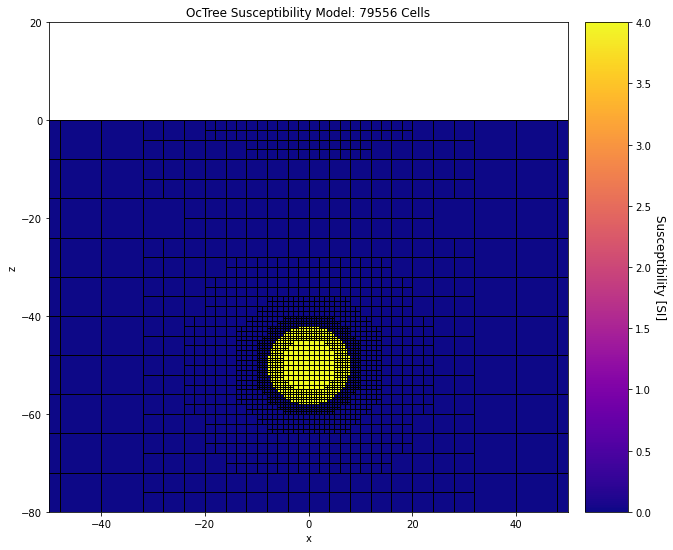

In [5]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh_simpeg.plot_slice(
    plotting_map * sus_model_simpeg[ind_active], normal="Y", ax=ax1, ind=int(mesh_simpeg.h[1].size / 2),
    clim=(np.min(sus_model_simpeg), np.max(sus_model_simpeg)), grid=True, pcolor_opts={'cmap':'plasma'}
)

ax1.set_xlim([-50, 50])
ax1.set_ylim([-80, 20])
ax1.set_title("OcTree Susceptibility Model: {} Cells".format(mesh_simpeg.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.min(sus_model_simpeg), vmax=np.max(sus_model_simpeg)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Susceptibility [SI]", rotation=270, labelpad=15, size=12)

## Plotting Simulated Data

Here we plot the simulated data for all codes.

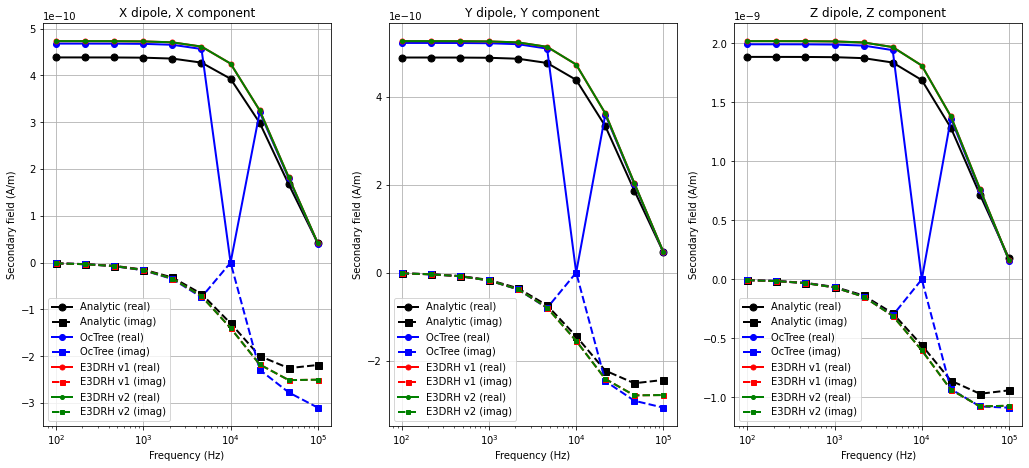

In [6]:
fig = plt.figure(figsize=(16, 7))
lw = 2
ms = [7, 6, 5, 4, 3]
ax = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):
    
    ax[ii] = fig.add_axes([0.05 + 0.3*ii, 0.1, 0.25, 0.8])

    for jj in range(0, len(data_list)):

        ax[ii].semilogx(
            frequencies, data_list[jj][ii, :, 2*ii], style_list_real[jj], lw=lw, markersize=ms[jj]
        )
        ax[ii].semilogx(
            frequencies, data_list[jj][ii, :, 2*ii+1], style_list_imag[jj], lw=lw, markersize=ms[jj]
        )

    ax[ii].grid()
    ax[ii].set_xlabel('Frequency (Hz)')
    ax[ii].set_ylabel('Secondary field (A/m)')
    ax[ii].set_title(comp + ' dipole, ' + comp + ' component')
    ax[ii].legend(legend_str)